# E-commerce Analytics 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- SETTINGS ----------------
DATA_DIR = Path('C:/Users/User/Desktop/AJAY/Self Project/Project/New folder (2)/Ecommerce/ecommerce')   # change to your dataset path
EXPORT_DIR = Path('./ecommerce_exports')
EXPORT_DIR.mkdir(exist_ok=True)

# ---------------- LOAD ----------------
products = pd.read_csv(DATA_DIR/'products.csv')
customers = pd.read_csv(DATA_DIR/'customers.csv', parse_dates=['signup_date'])
orders = pd.read_csv(DATA_DIR/'orders.csv', parse_dates=['order_date'])
shipments = pd.read_csv(DATA_DIR/'shipments.csv', parse_dates=['ship_date','delivery_date'])
returns = pd.read_csv(DATA_DIR/'returns.csv', parse_dates=['return_date'])
sessions = pd.read_csv(DATA_DIR/'sessions.csv', parse_dates=['visit_date'])

products.shape, customers.shape, orders.shape, shipments.shape, returns.shape, sessions.shape

((3000, 6), (60000, 4), (300000, 10), (300000, 7), (45000, 5), (1000000, 8))

In [2]:
# ---------------- CLEAN & DERIVE ----------------
orders['year_month'] = orders['order_date'].dt.to_period('M')
orders['margin'] = orders['revenue'] - orders['cost']
orders['aov_flag'] = 1

shipments['year_month'] = shipments['ship_date'].dt.to_period('M')
shipments['delivery_days'] = (shipments['delivery_date'] - shipments['ship_date']).dt.days.clip(lower=0)
shipments['on_time'] = (shipments['delay_days']<=0).astype(int)

returns['year_month'] = returns['return_date'].dt.to_period('M')

sessions['year_month'] = sessions['visit_date'].dt.to_period('M')
sessions['bounce'] = (sessions['pages_viewed']<=2).astype(int)

In [3]:
# ---------------- KPIs ----------------
kpi_m = orders.groupby('year_month').agg(
    orders_cnt=('order_id','count'),
    revenue=('revenue','sum'),
    cost=('cost','sum'),
    margin=('margin','sum'),
    aov=('revenue','mean')
).reset_index()
kpi_m['margin_pct'] = kpi_m['margin'] / kpi_m['revenue'].replace({0:np.nan})

sess_m = sessions.groupby('year_month').agg(sessions=('session_id','count')).reset_index()
ord_m = orders.groupby('year_month').agg(orders=('order_id','count')).reset_index()
conv_m = sess_m.merge(ord_m, on='year_month', how='left').fillna({'orders':0})
conv_m['conv_rate'] = conv_m['orders']/conv_m['sessions'].replace({0:np.nan})

ship_m = shipments.groupby('year_month').agg(
    on_time_rate=('on_time','mean'),
    avg_delivery_days=('delivery_days','mean')
).reset_index()

ret_m = returns.merge(orders[['order_id','year_month']].rename(columns={'year_month':'order_month'}), on='order_id', how='left')\
               .groupby('order_month').agg(returns=('return_id','count')).reset_index().rename(columns={'order_month':'year_month'})
ret_m = ret_m.merge(ord_m, on='year_month', how='left').fillna({'orders':0})
ret_m['return_rate'] = ret_m['returns']/ret_m['orders'].replace({0:np.nan})

# Repeat rate and CLV proxy
cust_ord = orders.groupby('customer_id').agg(n_orders=('order_id','count'), aov=('revenue','mean'), margin_pct=('margin','sum'))
cust_ord['margin_pct'] = cust_ord['margin_pct']/orders.groupby('customer_id')['revenue'].sum()
repeat_rate = (cust_ord['n_orders']>=2).mean()
clv_proxy = (cust_ord['aov'] * cust_ord['n_orders'] * cust_ord['margin_pct']).mean()

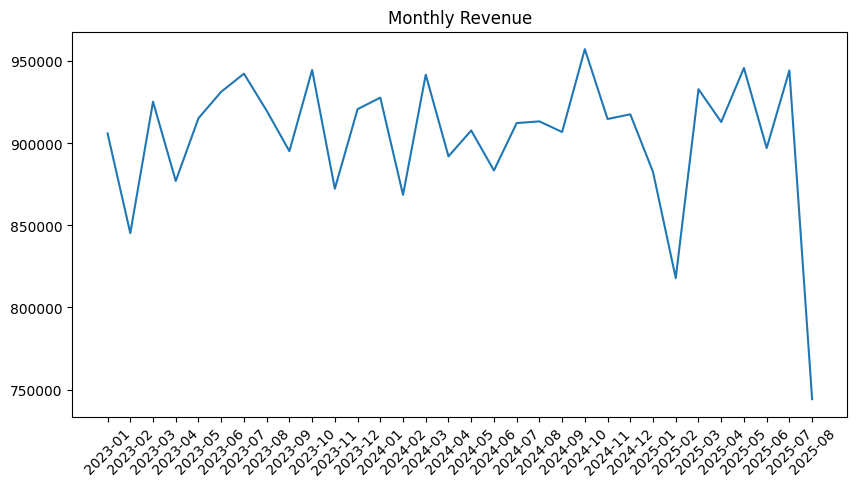

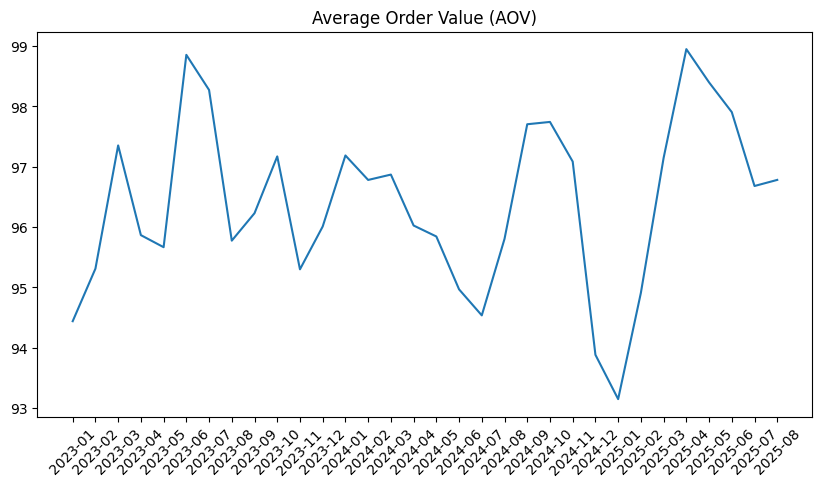

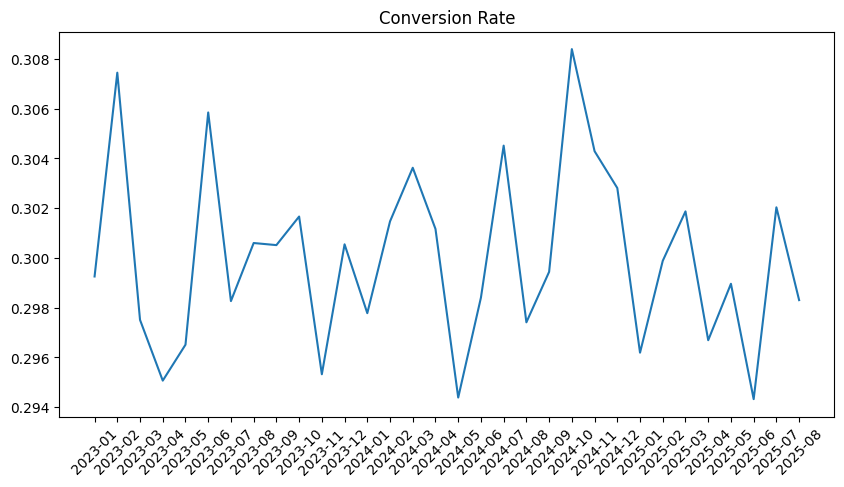

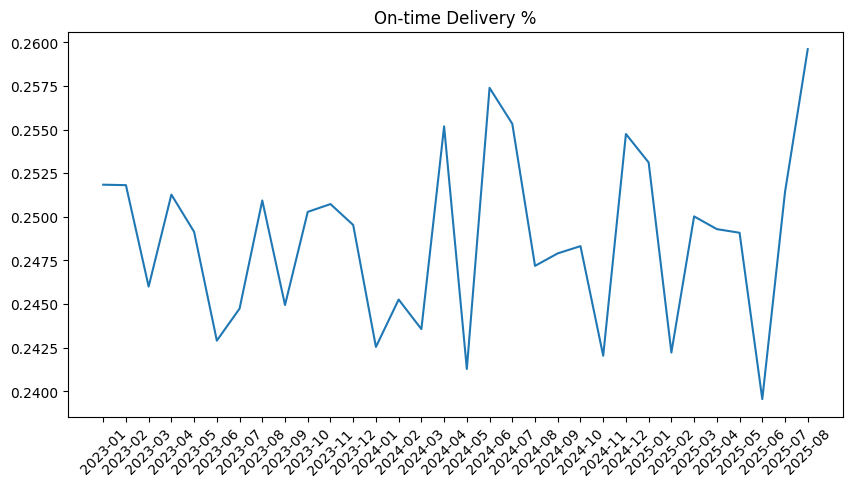

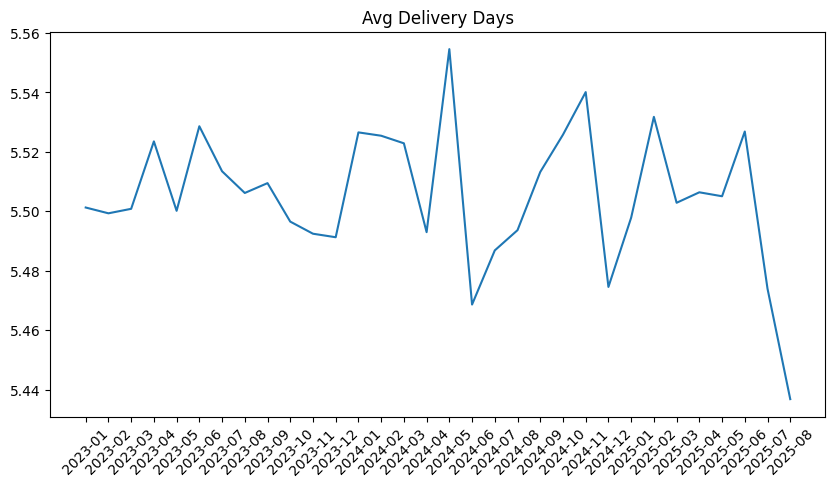

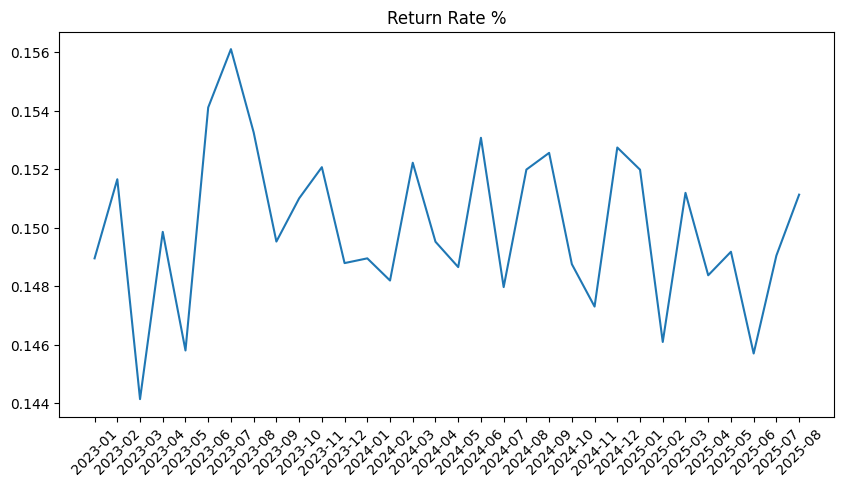

In [4]:
# ---------------- VISUALS ----------------
plt.figure(figsize=(10,5))
plt.plot(kpi_m['year_month'].astype(str), kpi_m['revenue'])
plt.xticks(rotation=45)
plt.title('Monthly Revenue')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(kpi_m['year_month'].astype(str), kpi_m['aov'])
plt.xticks(rotation=45)
plt.title('Average Order Value (AOV)')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(conv_m['year_month'].astype(str), conv_m['conv_rate'])
plt.xticks(rotation=45)
plt.title('Conversion Rate')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ship_m['year_month'].astype(str), ship_m['on_time_rate'])
plt.xticks(rotation=45)
plt.title('On-time Delivery %')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ship_m['year_month'].astype(str), ship_m['avg_delivery_days'])
plt.xticks(rotation=45)
plt.title('Avg Delivery Days')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ret_m['year_month'].astype(str), ret_m['return_rate'])
plt.xticks(rotation=45)
plt.title('Return Rate %')
plt.show()

In [ ]:
# ---------------- ANOMALY SPOTTING ----------------
rev = kpi_m[['year_month','revenue']].copy()
rev['z'] = (rev['revenue'] - rev['revenue'].mean())/rev['revenue'].std()
rev_anom = rev[np.abs(rev['z'])>3]
rev_anom.head()

delays = ship_m[['year_month','avg_delivery_days']].copy()
delays['z'] = (delays['avg_delivery_days'] - delays['avg_delivery_days'].mean())/delays['avg_delivery_days'].std()
delay_anom = delays[np.abs(delays['z'])>3]
delay_anom.head()

In [ ]:
# ---------------- EXPORTS FOR BI ----------------
kpi_m.to_csv(EXPORT_DIR/'sales_kpi_monthly.csv', index=False)
conv_m.to_csv(EXPORT_DIR/'conversion_monthly.csv', index=False)
ship_m.to_csv(EXPORT_DIR/'delivery_kpis_monthly.csv', index=False)
ret_m.to_csv(EXPORT_DIR/'returns_monthly.csv', index=False)
orders.merge(products[['product_id','category','sub_category','brand']], on='product_id', how='left')\
      .merge(customers[['customer_id','location','segment']], on='customer_id', how='left')\
      .to_csv(EXPORT_DIR/'orders_enriched.csv', index=False)
pd.DataFrame({'metric':['repeat_rate','clv_proxy'], 'value':[repeat_rate, clv_proxy]}).to_csv(EXPORT_DIR/'customer_metrics.csv', index=False)
print('Exported to', EXPORT_DIR)